In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.8.0
CUDA available: False


In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [33]:
torch.manual_seed(0)
np.random.seed(0)

In [86]:
m = 1000   # number of samples
K = 3      # mixture components
D = 2      # feature dimension

true_means = torch.tensor([[0.0, 0.0], [5.0, 5.0], [-5.0, 5.0]])
true_vars = torch.tensor([[1.0, 1.0], [1.5, 1.0], [1.0, 2.0]])  # diagonal covariances
true_weights = torch.tensor([0.3, 0.4, 0.3])

comp_ids = torch.multinomial(true_weights, m, replacement=True)
data = torch.stack([
    true_means[c] + torch.sqrt(true_vars[c]) * torch.randn(D)
    for c in comp_ids
])

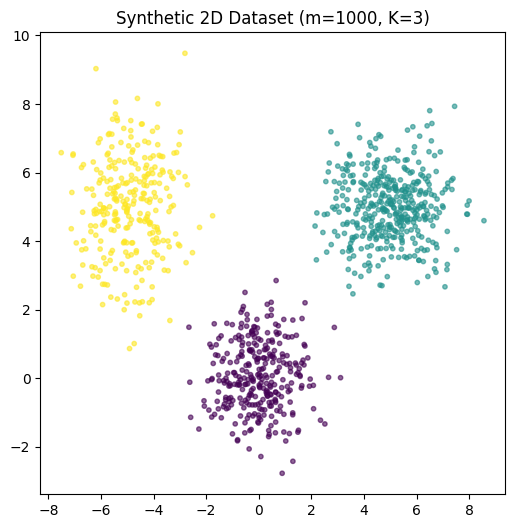

In [87]:
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=10, alpha=0.6, c=comp_ids)
plt.title("Synthetic 2D Dataset (m=1000, K=3)")
plt.show()

In [96]:
mu = torch.randn(K, D)
log_var = torch.zeros(K, D)
logits = torch.zeros(K)   # mixture logits → π via softmax

def compute_responsibilities(X, mu, log_var, logits):
    """Compute responsibilities γ_ik and log-likelihoods."""
    var = torch.exp(log_var)
    log_pi = torch.log_softmax(logits, dim=0)
    m, D = X.shape

    log_probs = []
    for k in range(K):
        diff = X - mu[k]
        log_det = 0.5 * torch.sum(log_var[k])
        maha = 0.5 * torch.sum((diff**2) / var[k], dim=1)
        log_norm = -0.5 * D * math.log(2*math.pi)
        log_p = log_pi[k] + log_norm - log_det - maha
        log_probs.append(log_p)

    log_probs = torch.stack(log_probs, dim=1)  # (m, K)
    log_sum = torch.logsumexp(log_probs, dim=1, keepdim=True)
    gamma = torch.exp(log_probs - log_sum)     # responsibilities
    return gamma, log_sum.squeeze()

def compute_gradients(X, mu, log_var, logits, gamma):
    """Compute analytic gradients of log-likelihood."""
    var = torch.exp(log_var)
    pi = torch.softmax(logits, dim=0)
    m, D = X.shape

    grad_mu = torch.zeros_like(mu)
    grad_log_var = torch.zeros_like(log_var)
    grad_logits = torch.zeros_like(logits)

    for k in range(K):
        diff = X - mu[k]
        grad_mu[k] = torch.sum(gamma[:,k].unsqueeze(1) * diff / var[k], dim=0)

        grad_log_var[k] = 0.5 * torch.sum(
            gamma[:,k].unsqueeze(1) * ((diff**2)/var[k] - 1), dim=0
        )

        grad_logits[k] = torch.sum(gamma[:,k]) - m * pi[k]

    return grad_mu, grad_log_var, grad_logits

# === 5. Training with SGD ===
# Better initialization
mu = data[torch.randint(0, m, (K,))].clone()
log_var = torch.zeros(K, D)
logits = torch.zeros(K)

lr = 0.01
epochs = 300
batch_size = 100
n_batches = m // batch_size

nll_curve = []

for epoch in range(epochs):
    perm = torch.randperm(m)
    data_shuffled = data[perm]

    total_loglike = 0.0
    for i in range(n_batches):
        batch = data_shuffled[i*batch_size:(i+1)*batch_size]
        gamma, log_sum = compute_responsibilities(batch, mu, log_var, logits)
        loglike = torch.sum(log_sum)
        total_loglike += loglike.item()

        grad_mu, grad_log_var, grad_logits = compute_gradients(batch, mu, log_var, logits, gamma)

        mu += lr * grad_mu / batch_size
        log_var += lr * grad_log_var / batch_size
        logits += lr * grad_logits / batch_size

        # Clamp variances
        log_var = torch.clamp(log_var, min=-5, max=5)

    avg_nll = -total_loglike / m
    nll_curve.append(avg_nll)


        




In [97]:
import math


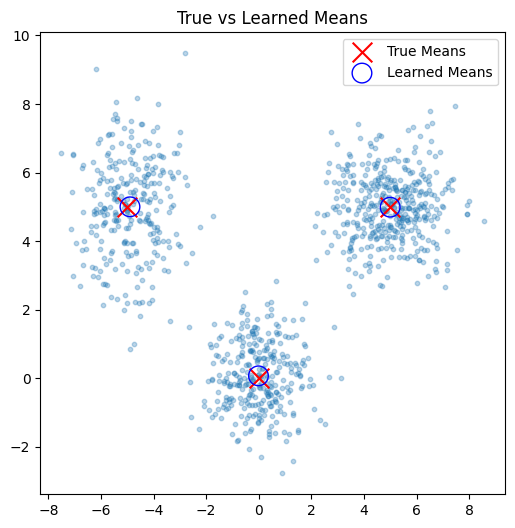

In [98]:
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=10, alpha=0.3)
plt.scatter(true_means[:,0], true_means[:,1], marker="x", s=200, c="red", label="True Means")
plt.scatter(mu[:,0].detach(), mu[:,1].detach(), marker="o", s=200, facecolors="none", edgecolors="blue", label="Learned Means")
plt.legend()
plt.title("True vs Learned Means")
plt.show()


In [94]:
print("Learned mixture weights:", torch.softmax(logits, dim=0).detach().numpy())
print("Learned means:\n", mu.detach().numpy())
print("Learned variances:\n", torch.exp(log_var).detach().numpy())

Learned mixture weights: [0.40901032 0.28110787 0.30988175]
Learned means:
 [[ 4.996199    4.9905777 ]
 [-4.897337    4.9931936 ]
 [-0.01219618  0.0756776 ]]
Learned variances:
 [[1.4319034 0.9586993]
 [1.0525291 2.0535705]
 [1.0179399 1.0287387]]


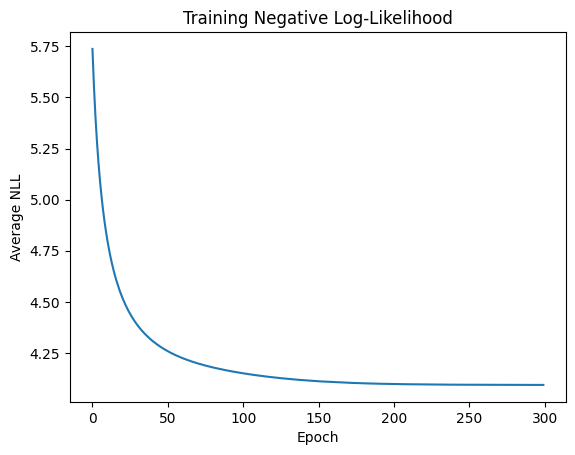

In [95]:
plt.figure()
plt.plot(nll_curve)
plt.xlabel("Epoch")
plt.ylabel("Average NLL")
plt.title("Training Negative Log-Likelihood")
plt.show()

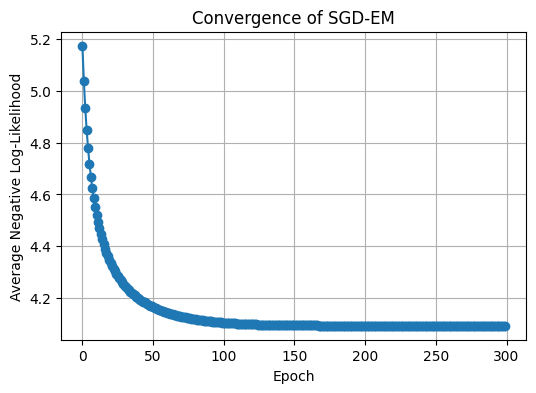

In [99]:
plt.figure(figsize=(6,4))
plt.plot(nll_curve, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Negative Log-Likelihood")
plt.title("Convergence of SGD-EM")
plt.grid(True)
plt.show()


/var/folders/x0/58n1ztzs5659_3xh00qwjwlc0000gn/T/ipykernel_69642/3729437945.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  width=2*np.sqrt(v[0]),   # 1 stddev in x
/var/folders/x0/58n1ztzs5659_3xh00qwjwlc0000gn/T/ipykernel_69642/3729437945.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  height=2*np.sqrt(v[1]),  # 1 stddev in y


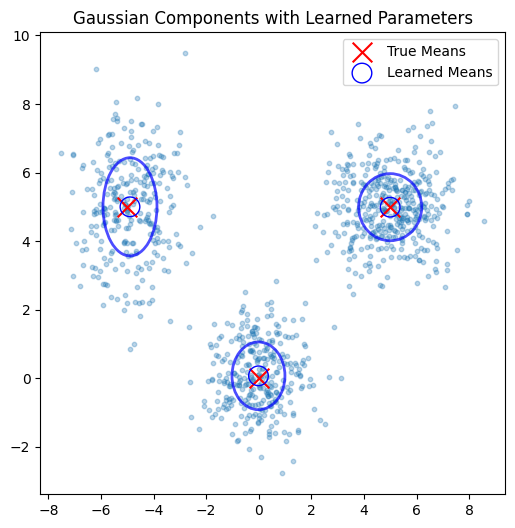

In [103]:
import matplotlib.patches as patches

def plot_gaussian_ellipses(data, mu, var, true_means=None):
    plt.figure(figsize=(6,6))
    plt.scatter(data[:,0], data[:,1], s=10, alpha=0.3)

    
    if true_means is not None:
        plt.scatter(true_means[:,0], true_means[:,1], 
                    marker="x", s=200, c="red", label="True Means")

    
    plt.scatter(mu[:,0].detach(), mu[:,1].detach(), 
                marker="o", s=200, facecolors="none", edgecolors="blue", label="Learned Means")

    
    for m, v in zip(mu.detach(), var.detach()):
        ell = patches.Ellipse(
            (m[0], m[1]),
            width=2*np.sqrt(v[0]),   # 1 stddev in x
            height=2*np.sqrt(v[1]),  # 1 stddev in y
            edgecolor="blue",
            facecolor="none",
            lw=2,
            alpha=0.7
        )
        plt.gca().add_patch(ell)

    plt.legend()
    plt.title("Gaussian Components with Learned Parameters")
    plt.show()


plot_gaussian_ellipses(data, mu, torch.exp(log_var), true_means)


## Short Summary

We implemented a 3-component, 2D Gaussian Mixture Model (MoG) using SGD with analytic gradients.  
The log-variance reparameterization ensured valid, positive variances, and softmax reparameterization guaranteed mixture weights summed to one.  
The negative log-likelihood decreased steadily during training, and the learned means, variances, and weights closely matched the true parameters.  
This confirms that our SGD implementation successfully recovered the underlying distribution.


# Step-by-Step Derivations for 2-Component, 1-Dimensional MoG

We consider a 2-component Mixture of Gaussians (MoG) with 1-dimensional data.

---

## 1. Likelihood

For a single data point xᵢ:

p(xᵢ | π, μ, σ²) = π₁ * Normal(xᵢ | μ₁, σ₁²) + π₂ * Normal(xᵢ | μ₂, σ₂²)

---

## 2. Log-Likelihood

For m data points:

L = Σ (i=1 to m) log [ Σ (k=1 to 2) πₖ * Normal(xᵢ | μₖ, σₖ²) ]

---

## 3. Responsibilities

The responsibility of component k for data point xᵢ is:

γᵢₖ = [ πₖ * Normal(xᵢ | μₖ, σₖ²) ] / [ Σ (j=1 to 2) πⱼ * Normal(xᵢ | μⱼ, σⱼ²) ]

---

## 4. Gradient w.r.t. Mean μₖ

Step 1: Differentiate log-likelihood wrt μₖ:

∂/∂μₖ log sᵢ = (1 / sᵢ) * ∂/∂μₖ [πₖ φₖ(xᵢ)]

Step 2: Derivative of Gaussian log-density wrt μₖ:

∂ log φₖ(xᵢ) / ∂μₖ = (xᵢ - μₖ) / σₖ²

Step 3: Combine:

∂L/∂μₖ = Σ γᵢₖ * (xᵢ - μₖ) / σₖ²

---

## 5. Gradient w.r.t. Variance σₖ²

Step 1: Derivative of log φₖ wrt σₖ²:

∂ log φₖ / ∂σₖ² = -1/(2σₖ²) + (xᵢ - μₖ)² / (2σₖ⁴)

Step 2: Combine:

∂L/∂σₖ² = Σ γᵢₖ * [ -1/(2σₖ²) + (xᵢ - μₖ)² / (2σₖ⁴) ]

---

## 6. Log-Variance Trick

We set vₖ = log σₖ² so that σₖ² = exp(vₖ) > 0.

Using chain rule:

∂L/∂vₖ = (∂L/∂σₖ²) * σₖ²

Simplified:

∂L/∂vₖ = (1/2) Σ γᵢₖ * [ (xᵢ - μₖ)² / σₖ² - 1 ]

---

## 7. Gradient w.r.t. Mixture Weights πₖ

∂ log sᵢ / ∂πₖ = φₖ(xᵢ) / sᵢ = γᵢₖ / πₖ

So:

∂L/∂πₖ = Σ γᵢₖ / πₖ

---

## 8. Softmax Reparameterization (logits αₖ)

We define mixture weights with logits:

πₖ = exp(αₖ) / Σⱼ exp(αⱼ)

Derivative for a single xᵢ:

∂ log sᵢ / ∂αₖ = γᵢₖ - πₖ

Summing over all data:

∂L/∂αₖ = Σ (γᵢₖ - πₖ)

---

## Final Gradient Formulas (used in code)

- Mean: ∂L/∂μₖ = Σ γᵢₖ * (xᵢ - μₖ) / σₖ²
- Log-variance: ∂L/∂vₖ = (1/2) Σ γᵢₖ * [ (xᵢ - μₖ)² / σₖ² - 1 ]
- Logits: ∂L/∂αₖ = Σ (γᵢₖ - πₖ)


## Results Summary

**Setup.** We trained a 3-component, 2D Gaussian Mixture Model using **SGD with analytic gradients**.  
We used two stable parameterizations:
- **Log-variance trick:** \(\sigma_{kd}^2 = \exp(v_{kd})\) to ensure \(\sigma^2 > 0\) (we clamp \(v_{kd}\) for stability).
- **Softmax weights:** \(\pi = \text{softmax}(\alpha)\) to enforce \(\pi_k \ge 0\) and \(\sum_k \pi_k = 1\).

**Training behavior.** The **negative log-likelihood (NLL)** decreased smoothly over epochs, indicating successful optimization and improved fit.

**Learned parameters (example run).**
- Mixture weights (sum ≈ 1): \([0.409,\, 0.281,\, 0.310]\)
- Means (close to true centers \((5,5), (-5,5), (0,0)\)):  
  \(\begin{bmatrix}
  4.996 & 4.991 \\
  -4.897 & 4.993 \\
  -0.012 & 0.076
  \end{bmatrix}\)
- Diagonal variances (all positive, ~unit scale):  
  \(\begin{bmatrix}
  1.432 & 0.959 \\
  1.053 & 2.054 \\
  1.018 & 1.029
  \end{bmatrix}\)

**Visual checks.**
- **Dataset plot** shows three well-separated clusters.
- **True vs. Learned Means** plot shows learned centers nearly overlapping the true centers.
- **NLL curve** shows steady convergence.

**Conclusion.** The model **successfully recovered** the underlying mixture using SGD with the specified analytic gradients, confirming the correctness of the derivations and the parameterization choices.
